# Python Dask

For those of you that are familiar with Pandas, Dask is simply a scalable framework that wraps around libraries like Pandas. A Dask DataFrame is a large parallel DataFrame composed of many smaller Pandas DataFrames, split along the index. These Pandas DataFrames may live on disk for larger-than-memory computing on a single machine, or on many different machines in a cluster. One Dask DataFrame operation triggers many operations on the constituent Pandas DataFrames.In this lecture, we're going to deep dive into using Dask and apply what we've learned in previous lectures to understand why the code works the way that it does.

## Getting Started
First, we are going import a dask dataframe. We start very similar to the way that we start with Pandas 

In [57]:
import dask.dataframe as dd

Let's now download some data for us to analyze. We will download New York's Taxi data from the first few months of 2020.

```
https://nyc-tlc.s3.amazonaws.com/trip+data/fhvhv_tripdata_2020-01.csv
https://nyc-tlc.s3.amazonaws.com/trip+data/fhvhv_tripdata_2020-02.csv
https://nyc-tlc.s3.amazonaws.com/trip+data/fhvhv_tripdata_2020-03.csv
https://nyc-tlc.s3.amazonaws.com/trip+data/fhvhv_tripdata_2020-04.csv
https://nyc-tlc.s3.amazonaws.com/trip+data/fhvhv_tripdata_2020-05.csv
https://nyc-tlc.s3.amazonaws.com/trip+data/fhvhv_tripdata_2020-06.csv
```
Here's a little trick that you should learn, you can download files directly from the command line using the wget command.

In [5]:
! wget https://nyc-tlc.s3.amazonaws.com/trip+data/fhvhv_tripdata_2020-01.csv

--2022-05-11 09:33:29--  https://nyc-tlc.s3.amazonaws.com/trip+data/fhvhv_tripdata_2020-01.csv
Resolving nyc-tlc.s3.amazonaws.com (nyc-tlc.s3.amazonaws.com)... 52.217.192.73
Connecting to nyc-tlc.s3.amazonaws.com (nyc-tlc.s3.amazonaws.com)|52.217.192.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1303901601 (1.2G) [text/csv]
Saving to: ‘fhvhv_tripdata_2020-01.csv’

fhvhv_tripdata_2020 100%[===================>]   1.21G  9.26MB/s    in 79s     

2022-05-11 09:34:48 (15.8 MB/s) - ‘fhvhv_tripdata_2020-01.csv’ saved [1303901601/1303901601]



In [6]:
! wget https://nyc-tlc.s3.amazonaws.com/trip+data/fhvhv_tripdata_2020-02.csv
! wget https://nyc-tlc.s3.amazonaws.com/trip+data/fhvhv_tripdata_2020-03.csv
! wget https://nyc-tlc.s3.amazonaws.com/trip+data/fhvhv_tripdata_2020-04.csv
! wget https://nyc-tlc.s3.amazonaws.com/trip+data/fhvhv_tripdata_2020-05.csv
! wget https://nyc-tlc.s3.amazonaws.com/trip+data/fhvhv_tripdata_2020-06.csv

--2022-05-11 09:37:27--  https://nyc-tlc.s3.amazonaws.com/trip+data/fhvhv_tripdata_2020-02.csv
Resolving nyc-tlc.s3.amazonaws.com (nyc-tlc.s3.amazonaws.com)... 52.216.245.12
Connecting to nyc-tlc.s3.amazonaws.com (nyc-tlc.s3.amazonaws.com)|52.216.245.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1377036387 (1.3G) [text/csv]
Saving to: ‘fhvhv_tripdata_2020-02.csv’

fhvhv_tripdata_2020 100%[===================>]   1.28G  11.0MB/s    in 88s     

2022-05-11 09:38:54 (15.0 MB/s) - ‘fhvhv_tripdata_2020-02.csv’ saved [1377036387/1377036387]

--2022-05-11 09:38:55--  https://nyc-tlc.s3.amazonaws.com/trip+data/fhvhv_tripdata_2020-03.csv
Resolving nyc-tlc.s3.amazonaws.com (nyc-tlc.s3.amazonaws.com)... 52.216.9.195
Connecting to nyc-tlc.s3.amazonaws.com (nyc-tlc.s3.amazonaws.com)|52.216.9.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 847836327 (809M) [text/csv]
Saving to: ‘fhvhv_tripdata_2020-03.csv’

fhvhv_tripdata_2020 100%[=======

Now, let's load some data into this notebook.

In [58]:
df = dd.read_csv('tripdata/fhvhv_tripdata_2020-01.csv')
df.head()

,hvfhs_license_num,dispatching_base_num,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,SR_Flag
0,HV0003,B02864,2020-01-01 00:45:34,2020-01-01 01:02:20,148,90,NaN
1,HV0003,B02682,2020-01-01 00:47:50,2020-01-01 00:53:23,114,79,NaN
2,HV0003,B02764,2020-01-01 00:04:37,2020-01-01 00:21:49,4,125,NaN
3,HV0003,B02764,2020-01-01 00:26:36,2020-01-01 00:33:00,231,113,NaN
4,HV0003,B02764,2020-01-01 00:37:49,2020-01-01 00:46:59,114,144,NaN


Let's do some basic analysis, how many rows are there in this dataset?

In [38]:
%time  len(df) #why does this take longer than loading

CPU times: user 30.9 s, sys: 5.32 s, total: 36.3 s
Wall time: 23 s


20569325

Why does this take longer than loading? Systems like Dask are often designed to load very large amounts of data from different files. For example, we can run code that looks like this:

In [131]:
df = dd.read_csv('tripdata/fhvhv_tripdata_2020-*.csv')
df.head()

,hvfhs_license_num,dispatching_base_num,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,SR_Flag
0,HV0003,B02864,2020-01-01 00:45:34,2020-01-01 01:02:20,148,90,NaN
1,HV0003,B02682,2020-01-01 00:47:50,2020-01-01 00:53:23,114,79,NaN
2,HV0003,B02764,2020-01-01 00:04:37,2020-01-01 00:21:49,4,125,NaN
3,HV0003,B02764,2020-01-01 00:26:36,2020-01-01 00:33:00,231,113,NaN
4,HV0003,B02764,2020-01-01 00:37:49,2020-01-01 00:46:59,114,144,NaN


Running code on these "lazy" DataFrames is a little more nuanced than simply using pandas. Let's see what happens with a simple example. Suppose, I ran

In [41]:
df[df['hvfhs_license_num'] == 'HV0003'] .count()

Dask Series Structure:
npartitions=1
DOLocationID       int64
pickup_datetime      ...
dtype: int64
Dask Name: dataframe-count-agg, 386 tasks

It returns almost immediately but doesn't give me the result. `df.count()` is description of what computation to do, and doesn't actually do the computation yet. To realize the answer, we need to explicitly run .compute()

In [42]:
%time df.count().compute()

CPU times: user 2min 17s, sys: 20.8 s, total: 2min 38s
Wall time: 1min 44s


hvfhs_license_num       73640833
dispatching_base_num    73640833
pickup_datetime         73640833
dropoff_datetime        73640833
PULocationID            73640833
DOLocationID            73640833
SR_Flag                  6896323
dtype: int64

We can also do some more complicated analyses. Let's try to figure out the average length of a trip.

In [140]:
df['dropoff_datetime_py'] = dd.to_datetime(df['dropoff_datetime'])
df.head()

,hvfhs_license_num,dispatching_base_num,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,SR_Flag,pickup_datetime_py,dropoff_datetime_py
0,HV0003,B02864,2020-01-01 00:45:34,2020-01-01 01:02:20,148,90,NaN,2020-01-01 00:45:34,2020-01-01 01:02:20
1,HV0003,B02682,2020-01-01 00:47:50,2020-01-01 00:53:23,114,79,NaN,2020-01-01 00:47:50,2020-01-01 00:53:23
2,HV0003,B02764,2020-01-01 00:04:37,2020-01-01 00:21:49,4,125,NaN,2020-01-01 00:04:37,2020-01-01 00:21:49
3,HV0003,B02764,2020-01-01 00:26:36,2020-01-01 00:33:00,231,113,NaN,2020-01-01 00:26:36,2020-01-01 00:33:00
4,HV0003,B02764,2020-01-01 00:37:49,2020-01-01 00:46:59,114,144,NaN,2020-01-01 00:37:49,2020-01-01 00:46:59


In [139]:
df['pickup_datetime_py'] = dd.to_datetime(df['pickup_datetime'])

In [141]:
df['difference'] = (df['dropoff_datetime_py'] - df['pickup_datetime_py'])

In [51]:
df.head(30)

,hvfhs_license_num,dispatching_base_num,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,SR_Flag,dropoff_datetime_py,pickup_datetime_py,difference,difference_seconds
0,HV0003,B02864,2020-01-01 00:45:34,2020-01-01 01:02:20,148,90,NaN,2020-01-01 01:02:20,2020-01-01 00:45:34,0 days 00:16:46,1006.0
1,HV0003,B02682,2020-01-01 00:47:50,2020-01-01 00:53:23,114,79,NaN,2020-01-01 00:53:23,2020-01-01 00:47:50,0 days 00:05:33,333.0
2,HV0003,B02764,2020-01-01 00:04:37,2020-01-01 00:21:49,4,125,NaN,2020-01-01 00:21:49,2020-01-01 00:04:37,0 days 00:17:12,1032.0
3,HV0003,B02764,2020-01-01 00:26:36,2020-01-01 00:33:00,231,113,NaN,2020-01-01 00:33:00,2020-01-01 00:26:36,0 days 00:06:24,384.0
4,HV0003,B02764,2020-01-01 00:37:49,2020-01-01 00:46:59,114,144,NaN,2020-01-01 00:46:59,2020-01-01 00:37:49,0 days 00:09:10,550.0
5,HV0003,B02764,2020-01-01 00:49:23,2020-01-01 01:07:26,144,137,NaN,2020-01-01 01:07:26,2020-01-01 00:49:23,0 days 00:18:03,1083.0
6,HV0003,B02870,2020-01-01 00:21:11,2020-01-01 00:36:58,249,148,NaN,2020-01-01 00:36:58,2020-01-01 00:21:11,0 days 00:15:47,947.0
7,HV0003,B02870,2020-01-01 00:38:28,2020-01-01 00:42:38,148,4,NaN,2020-01-01 00:42:38,2020-01-01 00:38:28,0 days 00:04:10,250.0
8,HV0003,B02870,2020-01-01 00:46:26,2020-01-01 01:09:55,79,7,NaN,2020-01-01 01:09:55,2020-01-01 00:46:26,0 days 00:23:29,1409.0
9,HV0003,B02836,2020-01-01 00:15:35,2020-01-01 00:23:21,140,236,NaN,2020-01-01 00:23:21,2020-01-01 00:15:35,0 days 00:07:46,466.0


How do you think the above code works with lazy evaluation?

In [142]:
df['difference_seconds'] = df['difference'].dt.total_seconds()
df.head()

,hvfhs_license_num,dispatching_base_num,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,SR_Flag,pickup_datetime_py,dropoff_datetime_py,difference,difference_seconds
0,HV0003,B02864,2020-01-01 00:45:34,2020-01-01 01:02:20,148,90,NaN,2020-01-01 00:45:34,2020-01-01 01:02:20,0 days 00:16:46,1006.0
1,HV0003,B02682,2020-01-01 00:47:50,2020-01-01 00:53:23,114,79,NaN,2020-01-01 00:47:50,2020-01-01 00:53:23,0 days 00:05:33,333.0
2,HV0003,B02764,2020-01-01 00:04:37,2020-01-01 00:21:49,4,125,NaN,2020-01-01 00:04:37,2020-01-01 00:21:49,0 days 00:17:12,1032.0
3,HV0003,B02764,2020-01-01 00:26:36,2020-01-01 00:33:00,231,113,NaN,2020-01-01 00:26:36,2020-01-01 00:33:00,0 days 00:06:24,384.0
4,HV0003,B02764,2020-01-01 00:37:49,2020-01-01 00:46:59,114,144,NaN,2020-01-01 00:37:49,2020-01-01 00:46:59,0 days 00:09:10,550.0


In [35]:
df['difference_seconds'].mean().compute(), df['difference_seconds'].std().compute()

(1013.1593988487339, 691.1400486498965)

In [53]:
!pip install geopandas

  Using cached geopandas-0.10.2-py2.py3-none-any.whl (1.0 MB)
  Using cached Shapely-1.8.2-cp39-cp39-macosx_10_9_x86_64.whl (1.2 MB)
     |████████████████████████████████| 18.5 MB 16.7 MB/s eta 0:00:01   |███████▍                        | 4.3 MB 8.7 MB/s eta 0:00:02
     |████████████████████████████████| 8.2 MB 458 kB/s eta 0:00:01
  Using cached munch-2.5.0-py2.py3-none-any.whl (10 kB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)
  Using cached certifi-2021.10.8-py2.py3-none-any.whl (149 kB)
  Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
You should consider upgrading via the '/Users/sanjaykrishnan/Documents/cmsc13600-public/venv/bin/python -m pip install --upgrade pip' command.


In [54]:
import geopandas as gpd

In [59]:
gdf = gpd.read_file('taxi-zones/geo_export_8fa447e4-1d62-4164-9635-24c69774a066.shp')

Text(79.10090243552189, 0.5, 'Latitude')

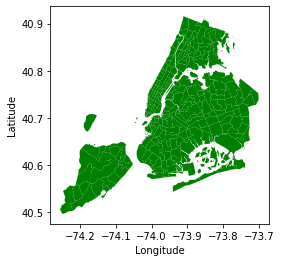

In [64]:
ax = gdf.plot(color='green')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [132]:
pickup_loc = df.groupby('PULocationID').count().compute()

In [133]:
pickup_loc = pickup_loc.reset_index()

In [134]:
gdf['location_i'] = gdf['location_i'].apply(int)

In [135]:
gdf = gdf.merge(pickup_loc, left_on=['location_i'], right_on=['PULocationID'])

Text(70.36680487104383, 0.5, 'Latitude')

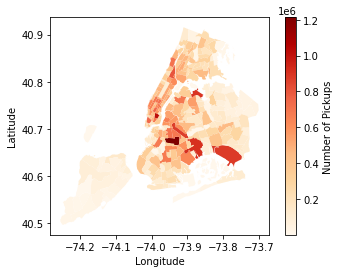

In [136]:
ax = gdf.plot(column='hvfhs_license_num', legend=True, cmap='OrRd', legend_kwds={'label': "Number of Pickups"})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

Text(70.36680487104383, 0.5, 'Latitude')

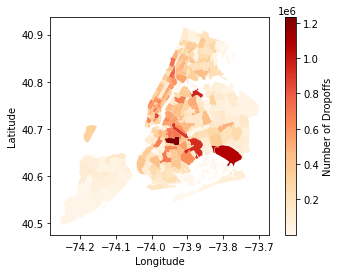

In [137]:
dropoff_loc = df.groupby('DOLocationID').count().compute()
dropoff_loc = dropoff_loc.reset_index()
gdf = gpd.read_file('taxi-zones/geo_export_8fa447e4-1d62-4164-9635-24c69774a066.shp')
gdf = gdf.merge(dropoff_loc, left_on=['location_i'], right_on=['DOLocationID'])

ax = gdf.plot(column='hvfhs_license_num', legend=True, cmap='OrRd', legend_kwds={'label': "Number of Dropoffs"})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [143]:
avg_trip_duration = df.groupby('PULocationID')['difference_seconds'].mean().compute()
avg_trip_duration = avg_trip_duration.reset_index()

Text(70.36680487104383, 0.5, 'Latitude')

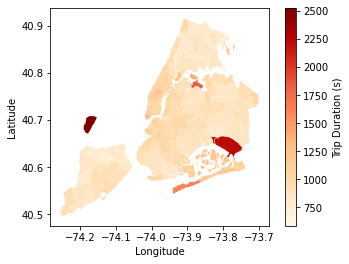

In [144]:
gdf = gpd.read_file('taxi-zones/geo_export_8fa447e4-1d62-4164-9635-24c69774a066.shp')
gdf = gdf.merge(avg_trip_duration, left_on=['location_i'], right_on=['PULocationID'])

ax = gdf.plot(column='difference_seconds', legend=True, cmap='OrRd', legend_kwds={'label': "Trip Duration (s)"})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [190]:
march_only = df.loc[df['pickup_datetime'].str.contains('2020-03')].compute()

In [205]:
import pandas as pd
after_pandemic = march_only.loc[march_only['pickup_datetime_py'].ge(pd.Timestamp(2020, 3, 20))]
before_pandemic = march_only[march_only['pickup_datetime_py'].lt(pd.Timestamp(2020, 3, 20))]

Text(70.36680487104383, 0.5, 'Latitude')

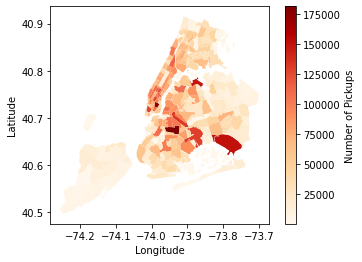

In [207]:
gdf = gpd.read_file('taxi-zones/geo_export_8fa447e4-1d62-4164-9635-24c69774a066.shp')

pickup_loc = before_pandemic.groupby('PULocationID').count()
pickup_loc = pickup_loc.reset_index()
gdf['location_i'] = gdf['location_i'].apply(int)
gdf = gdf.merge(pickup_loc, left_on=['location_i'], right_on=['PULocationID'])

ax = gdf.plot(column='hvfhs_license_num', legend=True, cmap='OrRd', legend_kwds={'label': "Number of Pickups"})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

Text(70.36680487104383, 0.5, 'Latitude')

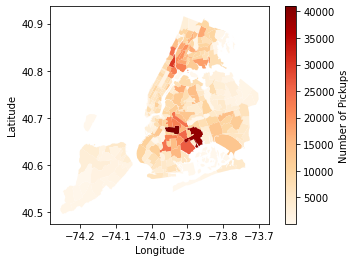

In [215]:
gdf = gpd.read_file('taxi-zones/geo_export_8fa447e4-1d62-4164-9635-24c69774a066.shp')

pickup_loc = after_pandemic.groupby('PULocationID').count()
pickup_loc = pickup_loc.reset_index()
gdf['location_i'] = gdf['location_i'].apply(int)
gdf = gdf.merge(pickup_loc, left_on=['location_i'], right_on=['PULocationID'])

ax = gdf.plot(column='hvfhs_license_num', legend=True, cmap='OrRd', legend_kwds={'label': "Number of Pickups"})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [222]:
pickup_loc_1 = before_pandemic.groupby('PULocationID').count()
pickup_loc_1 = pickup_loc_1.reset_index()

pickup_loc_2 = after_pandemic.groupby('PULocationID').count()
pickup_loc_2 = pickup_loc_2.reset_index()

out = pickup_loc_1.merge(pickup_loc_2, on='PULocationID')

out['difference'] = 100*(out['hvfhs_license_num_x'] - out['hvfhs_license_num_y'])/out['hvfhs_license_num_x']

Text(70.36680487104383, 0.5, 'Latitude')

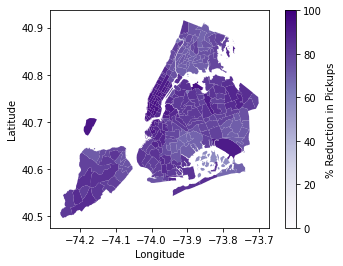

In [227]:
gdf = gpd.read_file('taxi-zones/geo_export_8fa447e4-1d62-4164-9635-24c69774a066.shp')

gdf['location_i'] = gdf['location_i'].apply(int)
gdf = gdf.merge(out, left_on=['location_i'], right_on=['PULocationID'])

ax = gdf.plot(column='difference', legend=True, cmap='Purples', legend_kwds={'label': "% Reduction in Pickups"}, vmin=0, vmax=100)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


In [228]:
businesses = pd.read_csv('/Users/sanjaykrishnan/Downloads/Legally_Operating_Businesses.csv')

/Users/sanjaykrishnan/Documents/cmsc13600-public/venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [229]:
businesses.head()

,DCA License Number,License Type,License Expiration Date,License Status,License Creation Date,Industry,Business Name,Business Name 2,Address Building,Address Street Name,...,Community Board,Council District,BIN,BBL,NTA,Census Tract,Detail,Longitude,Latitude,Location
0,0967332-DCA,Business,02/28/2017,Inactive,02/04/2010,Home Improvement Contractor,"BARBARINO, JOHN JR.",JOHN BARBARINO JR_HOME IMPROVEMENT,239,MEDFORD CT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1057563-DCA,Business,02/28/2023,Active,07/27/2000,Home Improvement Contractor,"HITE CONSTRUCTION, INC.",NaN,60,WHITNEY RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1314030-DCA,Business,01/31/2019,Inactive,04/10/2009,Debt Collection Agency,DYNAMIC RECOVERY SOLUTIONS LLC,NaN,135,INTERSTATE BLVD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1245882-DCA,Business,06/30/2022,Active,01/02/2007,Electronic & Appliance Service,"DELTA ELECTRONICS, INC.",NaN,3108,E TREMONT AVE,...,210.0,13.0,2073584.0,2053500039,NaN,NaN,NaN,-73.835446,40.838469,"(40.838469099008464, -73.83544554039032)"
4,2029953-DCA,Individual,10/31/2016,Inactive,10/29/2015,Tow Truck Driver,"Rodriguez, Juan",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
